In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import finesse
from scipy.optimize import minimize
from finesse.gaussian import BeamParam
import matplotlib.colors as colors
import scipy
from scipy.optimize import curve_fit

finesse.configure(plotting=True)
import warnings
warnings.filterwarnings('ignore')

### Beam-expanding telescopes **INSIDE** CE arms:

In [2]:
variables = """
# ------------------------------------------------------------------------------
# variables
# ------------------------------------------------------------------------------
variable nsilica 1.44963098985906
variable Mloss 30u

variable L_ARM 40k
variable TM_Rc 25.2049k

variable PRMRc 50
variable SEMRc -50
variable l_PRM_BS 50
variable l_BS_SEM 50

variable l_BS_XM2 50
variable XM2Rc -50
variable l_XM2_XM3 50
variable XM3Rc 50

variable l_XM3_ITMXlens 50

variable ITMX_lensf 10k
"""

In [3]:
base = finesse.Model()
base.parse(variables)
base.parse("""
l l1 P=165
s ll1_PRM l1.p1 PRMAR.p1

# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRMAR R=0 T=0.99996 # compound mirrors PRM, ITMX, and SEM
s sPRMsub PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM R=0.9699915 T=0.03 Rc=PRMRc
s lPRM_BS PRM.p2 BS.p1 L=l_PRM_BS

bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lBS_XM2 BS.p3 XM2.p1 L=l_BS_XM2
bs XM2 T=250u L=37.5u alpha=-1 Rc=XM2Rc
s lXM2_XM3 XM2.p2 XM3.p1 L=l_XM2_XM3
bs XM3 T=0 L=37.5u alpha=1 Rc=XM3Rc
s lXM3_ITMXlens XM3.p2 ITMX_lens.p1 L=l_XM3_ITMXlens

lens ITMX_lens ITMX_lensf

s lITMX ITMX_lens.p2 ITMXAR.p1

m ITMXAR T=0.99998 L=20u
s sITMXsub1 ITMXAR.p2 ITMX.p1 L=0.4 nr=nsilica
m ITMX T=0.014 L=Mloss phi=0 Rc=-TM_Rc

s LY ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=Mloss phi=0 Rc=TM_Rc

cav cavXARM source=ITMX.p2.o via=ETMX.p1.i priority=2
#cav cavPRX PRM.p2.o via=ITMX.p1.i priority=1
# ------------------------------------------------------------------------------
# Sginal recycling cavity
# ------------------------------------------------------------------------------
s lBS_SEM BS.p4 SEM.p1 L=l_BS_SEM
m SEM R=0.7999913 T=0.2 L=8.7u Rc=SEMRc
s SEMsub SEM.p2 SEMAR.p1 L=0.0749 nr=nsilica
m SEMAR R=0 T=0.99999995 L=50n
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Power detectors
# ------------------------------------------------------------------------------
"""
)

In [4]:
kat = base.deepcopy()

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30

XM2Rc = -9.6
XM3Rc = 100
ITMX_lensf = np.inf

SEMRc = -79.59188
PRMRc = 50
l_PRM_BS = 50

kat.PRMRc.value = PRMRc
kat.SEMRc.value = SEMRc
kat.l_PRM_BS.value = l_PRM_BS
kat.l_BS_SEM.value = l_BS_SEM
kat.l_BS_XM2.value = l_BS_XM2
kat.XM2Rc.value = XM2Rc
kat.l_XM2_XM3.value = l_XM2_XM3
kat.XM3Rc.value = XM3Rc
kat.l_XM3_ITMXlens.value = l_XM3_ITMXlens
kat.ITMX_lensf.value = ITMX_lensf

katt = kat.deepcopy()

In [5]:
ITMX_TO_SEM = katt.path(katt.ITMX.p1, katt.SEM.p1)
SEC_ps_sym = katt.propagate_beam(path=ITMX_TO_SEM, symbolic=True)
Rc_SEM_sym = SEC_ps_sym.q(katt.SEM.p1.i).Rc
# print(Rc_SEM_sym)
# Rc_SEM_sym.eval(subs={"XM3.alpha":1})

In [6]:
Rc_SEM_sym.eval()

-79.59188167303239

In [8]:
from sympy import *
import sympy as sp

L3_sym, L2_sym, L1_sym, R2_sym, R3_sym = symbols("L3_sym, L2_sym, L1_sym, R2_sym, R3_sym", real=True)

L3, L2, L1, R2, R3 = symbols("L3, L2, L1, R2, R3", real=True)

L3_num = 100
L2_num = 45.5
L1_num = 80

R2_num = -9.6
R3_num = 100
alpha_num = 1*np.pi/180

L3_sym = L3*L3_num
L2_sym = L2*L2_num
L1_sym = L1*L1_num

R2_sym = R2*R2_num
R3_sym = R3*R3_num

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30
XM2Rc = -9.6

subs={"lXM3_ITMXlens.L":l_XM3_ITMXlens, "lBS_XM2.L":l_BS_XM2, "lBS_SEM.L":l_BS_SEM, "XM2.Rc":XM2Rc, "ITMX_lens.f":np.inf, "lXM2_XM3.nr":1}

In [9]:
Rc_SEM_sympy = Rc_SEM_sym.eval(subs=subs, keep=["lXM2_XM3.L", "XM3.Rcx"]).to_sympy()
Rc_SEM_sympy = Rc_SEM_sympy.subs({"lXM2_XM3.L": L2_sym, "XM3.Rcx":R3_sym})
Rc_SEM_sympy_sim = cancel(simplify(Rc_SEM_sympy.evalf(n=25)))
factor(Rc_SEM_sympy_sim)

84.79271208680748696377238*(2.24487011618958546171217e-32*L2**6*R3**12 - 8.390671329839632989263453e-29*L2**6*R3**11 + 1.453395090806490649606449e-25*L2**6*R3**10 - 1.542163727590712796000709e-22*L2**6*R3**9 + 1.116125637053499390598088e-19*L2**6*R3**8 - 5.803498422011228240278273e-17*L2**6*R3**7 + 2.22283198634014247013944e-14*L2**6*R3**6 - 6.318714593317160682589689e-12*L2**6*R3**5 + 1.323094369418570139916766e-9*L2**6*R3**4 - 0.0000001990430831360441425967757*L2**6*R3**3 + 0.00002042392296454658516381816*L2**6*R3**2 - 0.001283781323340798899129475*L2**6*R3 + 0.03739593797792090587090698*L2**6 + 4.610937316967031377847918e-29*L2**5*R3**12 - 1.597410204862300814826161e-25*L2**5*R3**11 + 2.54253474162380162540199e-22*L2**5*R3**10 - 2.453598142532715673862511e-19*L2**5*R3**9 + 1.594811243028783857938216e-16*L2**5*R3**8 - 7.33047037448031771916005e-14*L2**5*R3**7 + 2.431271657645677720159438e-11*L2**5*R3**6 - 5.818799419502380401235711e-9*L2**5*R3**5 + 0.0000009849427245393121769642162*L

In [10]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

-79.59188182055111545096775

In [327]:
def get_indices(expr):
    a_count = 0
    b_count = 0
    for term in Mul.make_args(expr):
        if isinstance(term, Pow):
            base, exp = term.as_base_exp()
            if base == L2:
                a_count += exp
            elif base == R3:
                b_count += exp
    return a_count, b_count

get_indices(L2**3*R3**4)

(3, 4)

In [328]:
n_, d_ = fraction(Rc_SEM_sympy_sim)

nns = [nn for nn in n_.args if get_indices(nn)[0]<=4 and get_indices(nn)[1]<=4]
dds = [dd for dd in d_.args if get_indices(dd)[0]<=4 and get_indices(dd)[1]<=4]
    
n = Add(*nns)
d = Add(*dds)
Rc_SEM_sympy_sim = n/d
Rc_SEM_sympy_sim

(355199.5973276815578818997*L2**4*R3**4 - 27306576.15909354466077957*L2**4*R3**3 + 957278668.197853992880156*L2**4*R3**2 - 177837423.2001447658162614*L2**4*R3 + 8279978.138528405640101627*L2**4 + 36042061.2138370630019434*L2**3*R3**4 - 1405378920.793532227558219*L2**3*R3**3 + 391313088.283668019661664*L2**3*R3**2 - 36428796.57758742616250501*L2**3*R3 + 1131142.751114275666212848*L2**3 + 1159951205.892087716742936*L2**2*R3**4 - 430407437.9605033519757993*L2**2*R3**3 + 60091700.66349399088682902*L2**2*R3**2 - 3731457.551335150981612551*L2**2*R3 + 86906.93826866504022039167*L2**2 + 236640693.0839819368218556*L2*R3**4 - 44047823.14021399446605896*L2*R3**3 + 4102611.91730960323235629*L2*R3**2 - 191097.4005529010189310075*L2*R3 + 3560.545202896369435752506*L2 + 12105660.78289924477241084*R3**4 - 1503360.809718250947835665*R3**3 + 105038.5714094507937669986*R3**2 - 3914.177335748457033398552*R3 + 60.77061699920693820488617)/(4188.79181223150073192385*L2**4*R3**4 - 322023.5481224534144212836*L

In [329]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

84.77089418781670821118819

In [188]:
Rc_sym = cancel(simplify(Rc_SEM_sympy_sim.subs({L2:1})))
Rc_sym

(7.288306793470444920393799e-8*R3**12 - 0.000136645389407887727571347*R3**11 + 0.1094756947393550462154858*R3**10 - 47.93366551082720691066783*R3**9 + 12115.77796226415044687554*R3**8 - 1686388.484345926141815698*R3**7 + 103940138.8340651118539804*R3**6 - 589203621.5717260343810181*R3**5 + 1445096206.647325836398336*R3**4 - 1908802257.316510321015561*R3**3 + 1423840302.363887739679469*R3**2 - 567573161.0368640761648726*R3 + 94376712.61053175814806605)/(8.594908758260930490808817e-10*R3**12 - 0.000001611427827455666363067424*R3**11 + 0.001291026812327995877648202*R3**10 - 0.5652760920816655903842014*R3**9 + 142.8812337290021972751733*R3**8 - 19887.90523220159131078634*R3**7 + 1225845.420404957451162028*R3**6 - 6954838.677671095682371614*R3**5 + 17072674.46104974759087015*R3**4 - 22571096.74998477915531818*R3**3 + 16851614.58136581702376185*R3**2 - 6723438.529702786538138851*R3 + 1118985.082523288189973557)

In [12]:
ABCD = finesse.tracing.tools.compute_abcd(path=ITMX_TO_SEM, symbolic=True)

ABCD_sym = [[element.eval(subs=subs, keep=["lXM2_XM3.L", "XM3.Rcx"]).to_sympy().subs({"lXM2_XM3.L": L2_sym, "XM3.Rcx":R3_sym}) \
             for element in row] for row in ABCD.M]

ABCD_sym

[[-17.6692054673985 + 0.0200030465608782*(803.94884876663*L2 + 80.0)/R3,
  -803.94884876663*L2 - 1851.79605108295 + 2.00582414255046*(803.94884876663*L2 + 80.0)/R3],
 [-0.208365068342481 + 0.0200030465608782*(9.48061060958288*L2 + 1.0)/R3,
  -9.48061060958288*L2 - 21.8940014849006 + 2.00582414255046*(9.48061060958288*L2 + 1.0)/R3]]

In [13]:
def Propagation_sym(ABCD, q):
    ABCD_res = ABCD*Matrix([q, 1])
    q_res = ABCD_res[0]/ABCD_res[1]
    return q_res


q_in = katt.beam_trace()[katt.ITMX.p1.i][0].q
q_out_sym = Propagation_sym(sp.Matrix(ABCD_sym), q_in)

z_out, zR_out = q_out_sym.as_real_imag()

Rc_sym = z_out + zR_out**2/z_out
Rc_SEM_sympy_sim = cancel(simplify(Rc_sym.evalf(n=15)))
factor(Rc_SEM_sympy_sim)

84.8006454910728*(2.74509285549212e-12*L2**4*R3**4 + 4.90395878755676e-9*L2**4*R3**3 + 3.42208355263587e-6*L2**4*R3**2 + 0.001100378768192*L2**4*R3 + 0.13821265834151*L2**4 - 5.38701951692659e-9*L2**3*R3**4 - 7.51790676064303e-6*L2**3*R3**3 - 0.0036256668412334*L2**3*R3**2 - 0.60698451180164*L2**3*R3 + 0.0566636673152263*L2**3 + 4.12953679444351e-6*L2**2*R3**4 + 0.00398287202102098*L2**2*R3**3 + 1.0*L2**2*R3**2 - 0.186705510897963*L2**2*R3 + 0.00870903458486341*L2**2 - 0.0014587053350801*L2*R3**4 - 0.7324892329136*L2*R3**3 + 0.205101565908431*L2*R3**2 - 0.0191330850773538*L2*R3 + 0.000594743821185471*L2 + 0.201277432637907*R3**4 - 0.0751173389401869*R3**3 + 0.0105097827136831*R3**2 - 0.000653343872457601*R3 + 1.52264387517842e-5)/(2.7451374168366e-12*L2**4*R3**4 + 4.90403839397023e-9*L2**4*R3**3 + 3.42213910363252e-6*L2**4*R3**2 + 0.00110039663074162*L2**4*R3 + 0.138214901960289*L2**4 - 5.38709057748268e-9*L2**3*R3**4 - 7.51799952426954e-6*L2**3*R3**3 - 0.00362570526814705*L2**3*R3**2 

In [14]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

29.3426966673685

In [15]:
SEMRc = -79.59188167302904
Rc_sym = cancel(simplify(Rc_SEM_sympy_sim.subs({R3:1})))
sp.solve(Rc_sym-SEMRc, L2, dict=True)

[{L2: 0.994373685722442}, {L2: 0.996819646719770}]

In [82]:
# LXM3XM2s = []
# RcXM3_vals = np.linspace(95, 105,50)
# RcXM3_vals = RcXM3_vals/R3_num
# for RcXM3_val in RcXM3_vals:
#     Rc_sym_3 = simplify(Rc_SEM_sympy_sim.subs({R3:RcXM3_val}).evalf())
#     sol = solve(Rc_sym_3-SEMRc, L2, dict=True)
#     if sol:
#         sols = []
#         for soll in sol:
#             sols.append(soll[L2])
#         LXM3XM2s.append(sols)
# LXM3XM2s = np.array(LXM3XM2s)

In [83]:
# fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(LXM3XM2s[:,0])
# ax.plot(LXM3XM2s[:,1])
# ax.set_ylabel("L XM3XM2", fontsize=15) 
# ax.set_xlabel("XM3 Rc", fontsize=15);

#### For BeamSplitters (tangential "x" and sagittal "y"):
Reflection:
$$
M_x=\left(\begin{array}{cc}
1 & 0 \\
-\frac{2 n_1}{R_c \cos \alpha_1} & 1
\end{array}\right),
M_y=\left(\begin{array}{cc}
1 & 0 \\
-\frac{2 n_1 \cos \alpha_2}{R_c} & 1
\end{array}\right)
$$

Transmission:
$$
M_t=\left(\begin{array}{cc}
1 & 0 \\
\frac{\Delta n}{R} & 1
\end{array}\right)
$$

#### For Spaces:
$$
M_s=\left(\begin{array}{cc}
1 & \frac{L}{n_r} \\
0 & 1
\end{array}\right), \text{  Beam tracing:   }
\frac{q_2}{n_2}=\frac{A \frac{q_1}{n_1}+B}{C \frac{q_1}{n_1}+D}
$$

In [11]:
def ABCD_BS(R, astigmatism):
    return np.array([[1, 0], [-2/R*astigmatism, 1]])

def ABCD_T(R, deltan):
    return np.array([[1, 0], [deltan/R, 1]])

def ABCD_S(L):
    return np.array([[1, L], [0, 1]])

def Propagation(ABCD, q, n1=1, n2=1):
    ABCD_res = ABCD@np.array([q/n1, 1])
    q_res = ABCD_res[0]/ABCD_res[1]*n2
    return q_res

In [12]:
L_ITMX_XM3_sym = 100
L_XM3_XM2_sym = 45.5
L_XM2_BS_fix = 50
L_BS_SEM_sym = 30

XM2Rc_sym = -9.6
XM3Rc_sym = 100
alpha_fix = 1*np.pi/180
ITMR = 25.2049e3

# M_t_ITMX = ABCD_T(ITMR, 1-1.44963098985906)
# M_s_ITMXsub = ABCD_S(0.4/1.44963098985906)
M_s_ITMX_XM3 = ABCD_S(L_ITMX_XM3_sym)
M_s_XM3_XM2 = ABCD_S(L_XM3_XM2_sym)
M_s_XM2_BS = ABCD_S(L_XM2_BS_fix)
M_s_BS_SEM = ABCD_S(L_BS_SEM_sym)
# M_s_SEMsub = ABCD_S(0.4/1.44963098985906)

M_x_XM3 = ABCD_BS(XM3Rc_sym, 1/np.cos(alpha_fix))
M_x_XM2 = ABCD_BS(XM2Rc_sym, 1/np.cos(alpha_fix))
M_x_BS = ABCD_BS(np.inf, 1)

q_in_0 = SEC_ps_sym.q(katt.ITMXAR.p1.o).q.eval()
q_in_0

(15471.415708812849+5444.475430987707j)

In [13]:
BeamParam(q=q_in_0).w0, BeamParam(q=q_in_0).z

(0.042941172520941984, 15471.415708812849)

In [14]:
M_tot = [M_s_ITMX_XM3, M_x_XM3, M_s_XM3_XM2, M_x_XM2, M_s_XM2_BS, M_x_BS, M_s_BS_SEM,]
# M_tot = M_s_ITMX_XM3@M_x_XM3@M_s_XM3_XM2@M_x_XM2@M_s_XM2_BS@M_x_BS@M_s_BS_SEM
q_in = q_in_0
for M in M_tot:
    q_out = Propagation(M, q_in)
    q_in = q_out

print(BeamParam(q=q_out).Rc)

M_tot = M_s_BS_SEM@M_x_BS@M_s_XM2_BS@M_x_XM2@M_s_XM3_XM2@M_x_XM3@M_s_ITMX_XM3
q_out = Propagation(M_tot, q_in_0)
print(BeamParam(q=q_out).Rc)

-79.59188167302904
-79.5918816730291


(-10.0, 235.0)

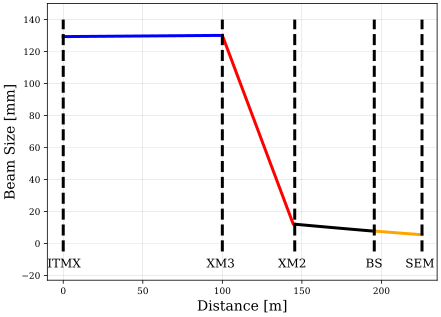

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))

beamsizes = []
q_out = q_in_0
for LL in np.linspace(0, L_ITMX_XM3_sym, 50):
    M_space = ABCD_S(LL)
    q_out1 = Propagation(M_space, q_out)
    beamsizes.append(BeamParam(q=q_out1).w)

q_out1 = Propagation(M_x_XM3, q_out1)
beamsizes.append(BeamParam(q=q_out1).w)
ax.plot(np.linspace(0, L_ITMX_XM3_sym, 51), np.array(beamsizes)*1e3, lw=3)
ax.vlines(0, -5, 140, color="k", linestyles='--', lw=3)
ax.text(-10, -15, "ITMX", color="k", fontsize=12)
ax.text(90, -15, "XM3", color="k", fontsize=12)

beamsizes = []
for LL in np.linspace(0, L_XM3_XM2_sym, 50):
    M_space = ABCD_S(LL)
    q_out2 = Propagation(M_space, q_out1)
    beamsizes.append(BeamParam(q=q_out2).w)

q_out2 = Propagation(M_x_XM2, q_out2)
beamsizes.append(BeamParam(q=q_out2).w)  
ax.plot(L_ITMX_XM3_sym+np.linspace(0, L_XM3_XM2_sym, 51), np.array(beamsizes)*1e3, lw=3)
ax.vlines(L_ITMX_XM3_sym, -5, 140, color="k", linestyles='--', lw=3)
ax.text(135, -15, "XM2", color="k", fontsize=12)

beamsizes = []
for LL in np.linspace(0, L_XM2_BS_fix, 50):
    M_space = ABCD_S(LL)
    q_out3 = Propagation(M_space, q_out2)
    beamsizes.append(BeamParam(q=q_out3).w)
q_out3 = Propagation(M_x_BS, q_out3)
beamsizes.append(BeamParam(q=q_out3).w)  
ax.plot(L_ITMX_XM3_sym+L_XM3_XM2_sym+np.linspace(0, L_XM2_BS_fix, 51), np.array(beamsizes)*1e3, lw=3)
ax.vlines(L_ITMX_XM3_sym+L_XM3_XM2_sym, -5, 140, color="k", linestyles='--', lw=3)
ax.text(190, -15, "BS", color="k", fontsize=12)

beamsizes = []
for LL in np.linspace(0, L_BS_SEM_sym, 50):
    M_space = ABCD_S(LL)
    q_out4 = Propagation(M_space, q_out3)
    beamsizes.append(BeamParam(q=q_out4).w)
    
ax.plot(L_ITMX_XM3_sym+L_XM3_XM2_sym+L_XM2_BS_fix+np.linspace(0, L_BS_SEM_sym, 50), np.array(beamsizes)*1e3, lw=3)
ax.vlines(L_ITMX_XM3_sym+L_XM3_XM2_sym+L_XM2_BS_fix, -5, 140, color="k", linestyles='--', lw=3)
ax.vlines(L_ITMX_XM3_sym+L_XM3_XM2_sym+L_XM2_BS_fix+L_BS_SEM_sym, -5, 140, color="k", linestyles='--', lw=3)

ax.text(215, -15, "SEM", color="k", fontsize=12)

ax.set_ylabel("Beam Size [mm]", fontsize=14)
ax.set_xlabel("Distance [m]", fontsize=14)
ax.set_ylim([-23, 150])
ax.set_xlim([-10, 235])

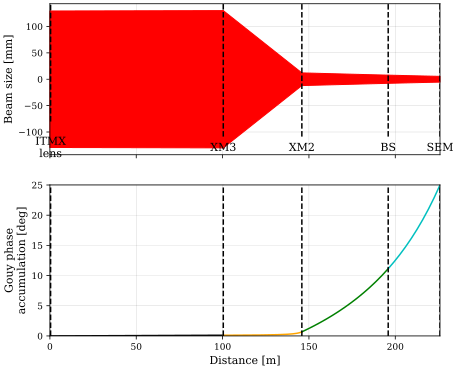

SEC RoC is -79.59188167303567


In [21]:
pb_SEC = katt.propagate_beam(path=ITMX_TO_SEM)

pb_SEC.plot(figsize=(7, 3));
SEM_Rc_fixed = pb_SEC.q(katt.SEM.p1.i).Rc
print(f"SEC RoC is {SEM_Rc_fixed}")

In [22]:
# ITMX_TO_SEM.nodes_only
# katt.XM2.ABCD(katt.XM2.p2.i, katt.XM2.p1.o)
# pb_SEC.abcd(up_to="SEM.p1.i")

In [7]:
from sympy.matrices import Matrix
from sympy import *
import sympy as sp

import numpy as np

from sympy import solve
SEMRc = -79.59188167302904

In [8]:
def ABCD_BS_sym(R, astigmatism):
    return Matrix([[1, 0], [-2/R*astigmatism, 1]])

def ABCD_S_sym(L):
    return Matrix([[1, L], [0, 1]])

def Propagation_sym(ABCD, q):
    ABCD_res = ABCD*Matrix([q, 1])
    q_res = ABCD_res[0]/ABCD_res[1]
    return q_res

In [9]:
L_ITMX_XM3_sym = 100
L_XM3_XM2_sym = 45.5
L_XM2_BS_fix = 50
L_BS_SEM_sym = 30

XM2Rc_sym = -9.6
XM3Rc_sym = 100
alpha_fix = 1*np.pi/180
ITMR = 25.2049e3

In [15]:
L_ITMX_XM3, L_XM3_XM2, L_XM2_BS, L_BS_SEM, Rc_XM2, Rc_XM3 = symbols("L_ITMX_XM3, L_XM3_XM2, L_XM2_BS, L_BS_SEM, Rc_XM2, Rc_XM3", real=True)

M_s_ITMX_XM3_sym = ABCD_S_sym(L_ITMX_XM3)
M_s_XM3_XM2_sym = ABCD_S_sym(L_XM3_XM2)
M_s_XM2_BS_sym = ABCD_S_sym(L_XM2_BS)
M_s_BS_SEM_sym = ABCD_S_sym(L_BS_SEM)

M_x_XM3_sym = ABCD_BS_sym(Rc_XM3, 1/np.cos(alpha_fix))
M_x_XM2_sym = ABCD_BS_sym(Rc_XM2, 1/np.cos(alpha_fix))
M_x_BS_sym = ABCD_BS_sym(np.inf, 1)
M_tot_sym = M_s_BS_SEM_sym@M_x_BS_sym@M_s_XM2_BS_sym@M_x_XM2_sym@M_s_XM3_XM2_sym@M_x_XM3_sym@M_s_ITMX_XM3_sym

q_out_sym = simplify(Propagation_sym(M_tot_sym, q_in_0).subs({L_XM2_BS:L_XM2_BS_fix,}))
print(q_out_sym)

(-L_XM3_XM2*Rc_XM3*(-2.00030465608782*L_BS_SEM + Rc_XM2 - 100.015232804391) - Rc_XM2*Rc_XM3*(L_BS_SEM + 50) + (L_ITMX_XM3 + 15471.4157088128 + 5444.47543098771*I)*(2.00030465608782*L_XM3_XM2*(-2.00030465608782*L_BS_SEM + Rc_XM2 - 100.015232804391) - Rc_XM2*Rc_XM3 + 2.00030465608782*Rc_XM2*(L_BS_SEM + 50) + Rc_XM3*(2.00030465608782*L_BS_SEM + 100.015232804391)))/(2.00030465608782*L_XM3_XM2*Rc_XM3 - Rc_XM2*Rc_XM3 + (L_ITMX_XM3 + 15471.4157088128 + 5444.47543098771*I)*(-4.00121871716659*L_XM3_XM2 + 2.00030465608782*Rc_XM2 + 2.00030465608782*Rc_XM3))


In [27]:
q_eval = q_out_sym.subs({L_ITMX_XM3:L_ITMX_XM3_sym, L_XM3_XM2:L_XM3_XM2_sym, L_BS_SEM:L_BS_SEM_sym,
               Rc_XM2:XM2Rc_sym, Rc_XM3:XM3Rc_sym}).evalf()
BeamParam(q=q_eval).Rc

-79.59188167303874

In [28]:
real, imag = q_out_sym.as_real_imag()
zR = simplify(imag)
z = simplify(real)

w0_sym = sqrt(zR*1064e-9/np.pi)
w_sym = w0_sym*sqrt(1+(z/zR)**2)
Rc_sym = z + zR**2/z
print(w0_sym)
print()
print(w_sym)
print()
print(Rc_sym)

0.000581963674896942*sqrt((-(-21784.5369996217*L_XM3_XM2 + 10890.6095545604*Rc_XM2 + 10890.6095545604*Rc_XM3)*(L_XM3_XM2*Rc_XM3*(2.00030465608782*L_BS_SEM - Rc_XM2 + 100.015232804391) - Rc_XM2*Rc_XM3*(L_BS_SEM + 50) - (L_ITMX_XM3 + 15471.4157088128)*(2.00030465608782*L_XM3_XM2*(2.00030465608782*L_BS_SEM - Rc_XM2 + 100.015232804391) + Rc_XM2*Rc_XM3 - 2.00030465608782*Rc_XM2*(L_BS_SEM + 50) - Rc_XM3*(2.00030465608782*L_BS_SEM + 100.015232804391))) - (2.00030465608782*L_XM3_XM2*Rc_XM3 - Rc_XM2*Rc_XM3 + (L_ITMX_XM3 + 15471.4157088128)*(-4.00121871716659*L_XM3_XM2 + 2.00030465608782*Rc_XM2 + 2.00030465608782*Rc_XM3))*(10890.6095545604*L_XM3_XM2*(2.00030465608782*L_BS_SEM - Rc_XM2 + 100.015232804391) + 5444.47543098771*Rc_XM2*Rc_XM3 - 10890.6095545604*Rc_XM2*(L_BS_SEM + 50) - 5444.47543098771*Rc_XM3*(2.00030465608782*L_BS_SEM + 100.015232804391)))/(474566052.287885*(-L_XM3_XM2 + 0.499923847578196*Rc_XM2 + 0.499923847578196*Rc_XM3)**2 + 4.00121871716659*(L_XM3_XM2*Rc_XM3 - 0.499923847578196*R

In [29]:
print(Rc_sym.subs({L_ITMX_XM3:L_ITMX_XM3_sym, L_XM3_XM2:L_XM3_XM2_sym, L_BS_SEM:L_BS_SEM_sym,
               Rc_XM2:XM2Rc_sym, Rc_XM3:XM3Rc_sym}))

-79.5918816730443


<div style="text-align:center">
<img src="./Assets/reverse_aLIGO1.png" alt="CE drawing" width="500"/>
</div>

#### For BeamSplitters (tangential "x" and sagittal "y"):
Reflection:
$$
M_x=\left(\begin{array}{cc}
1 & 0 \\
-\frac{2 n_1}{R_c \cos \alpha_1} & 1
\end{array}\right),
M_y=\left(\begin{array}{cc}
1 & 0 \\
-\frac{2 n_1 \cos \alpha_2}{R_c} & 1
\end{array}\right)
$$

Transmission:
$$
M_t=\left(\begin{array}{cc}
1 & 0 \\
\frac{\Delta n}{R} & 1
\end{array}\right)
$$

#### For Spaces:
$$
M_s=\left(\begin{array}{cc}
1 & \frac{L}{n_r} \\
0 & 1
\end{array}\right), \text{  Beam tracing:   }
\frac{q_2}{n_2}=\frac{A \frac{q_1}{n_1}+B}{C \frac{q_1}{n_1}+D}
$$

In [16]:
L3_sym, L2_sym, L1_sym, R2_sym, R3_sym = symbols("L3_sym, L2_sym, L1_sym, R2_sym, R3_sym", real=True)

L3, L2, L1, R2, R3 = symbols("L3, L2, L1, R2, R3", real=True)

alpha, z, w0 = symbols("alpha, z, w0", real=True)
lamb = symbols('lambda', real = True, constant = True)
Rc = symbols('Rc', real = True,) # SEM Rc
q_in = z + sp.I*sp.pi*w0**2/lamb

L3_num = 100
L2_num = 45.5
L1_num = 80

R2_num = -9.6
R3_num = 100
alpha_num = 1*np.pi/180

L3_sym = L3*L3_num
L2_sym = L2*L2_num
L1_sym = L1*L1_num

R2_sym = R2*R2_num
R3_sym = R3*R3_num

M_s_ITMX_XM3_sym = ABCD_S_sym(L3_sym)
M_s_XM3_XM2_sym = ABCD_S_sym(L2_sym)
M_s_XM2_SEM_sym = ABCD_S_sym(L1_sym)

M_x_XM3_sym = ABCD_BS_sym(R3_sym, 1/sp.cos(alpha))
M_x_XM2_sym = ABCD_BS_sym(R2_sym, 1/sp.cos(alpha))
M_tot_sym = M_s_XM2_SEM_sym@M_x_XM2_sym@M_s_XM3_XM2_sym@M_x_XM3_sym@M_s_ITMX_XM3_sym

# q_out_sym = simplify(Propagation_sym(M_tot_sym, q_in))
q_out_sym = Propagation_sym(M_tot_sym, q_in)
q_out_sym

(80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1) + 100*L3*(16.6666666666667*L1/(R2*cos(alpha)) + 1 - (80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1))/(50*R3*cos(alpha))) + (z + I*pi*w0**2/lambda)*(16.6666666666667*L1/(R2*cos(alpha)) + 1 - (80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1))/(50*R3*cos(alpha))))/(9.47916666666667*L2/(R2*cos(alpha)) + 100*L3*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha))) + (z + I*pi*w0**2/lambda)*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha))) + 1)

In [17]:
z_out, zR_out = q_out_sym.as_real_imag()

Rc_sym = z_out + zR_out**2/z_out
Rc_sym

(80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1) + 100*L3*(16.6666666666667*L1/(R2*cos(alpha)) + 1 - (80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1))/(50*R3*cos(alpha))) + z*(16.6666666666667*L1/(R2*cos(alpha)) + 1 - (80*L1 + 45.5*L2*(16.6666666666667*L1/(R2*cos(alpha)) + 1))/(50*R3*cos(alpha))))*(9.47916666666667*L2/(R2*cos(alpha)) + 100*L3*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha))) + z*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha))) + 1)/(10000*(0.0947916666666667*L2/(R2*cos(alpha)) + L3*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha))) + z*(-(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(50*R3*cos(alpha)) + 0.208333333333333/(R2*cos(alpha)))/100 + 1/100)**2 + 0.0434027777777778*pi**2*w0**4*(-0.096*(9.47916666666667*L2/(R2*cos(alpha)) + 1)/(R3*cos(alpha)) + 1/(R2*cos(alpha)))**2/lambda**2) + (-pi*w0**2*(-(9.479

In [18]:
w0_in, z_in = BeamParam(q=q_in_0).w0, BeamParam(q=q_in_0).z
Rc_sym_1 = Rc_sym.subs({alpha:alpha_num, lamb:1064e-9, w0:w0_in, z:z_in})
Rc_sym_1

3003394.21054779*(-pi*(-0.0200030465608782*(9.48061060958288*L2/R2 + 1)/R3 + 0.208365068342481/R2)*(80*L1 + 257896.207321738*L1/R2 + 45.5*L2*(16.6692054673985*L1/R2 + 1) + 100*L3*(16.6692054673985*L1/R2 + 1 - 0.0200030465608782*(80*L1 + 45.5*L2*(16.6692054673985*L1/R2 + 1))/R3) + 15471.4157088128 - 309.475448786085*(80*L1 + 45.5*L2*(16.6692054673985*L1/R2 + 1))/R3)/(130395.368167031*pi**2*(-0.096*(9.48061060958288*L2/R2 + 1)/R3 + 1/R2)**2 + 10392258.3985839*(0.00294090733882112*L2/R2 + 0.0310202312902556*L3*(-0.0200030465608782*(9.48061060958288*L2/R2 + 1)/R3 + 0.208365068342481/R2) + 0.000310202312902556 - 0.096*(9.48061060958288*L2/R2 + 1)/R3 + 1/R2)**2) + pi*(16.6692054673985*L1/R2 + 1 - 0.0200030465608782*(80*L1 + 45.5*L2*(16.6692054673985*L1/R2 + 1))/R3)*(9.48061060958288*L2/R2 + 100*L3*(-0.0200030465608782*(9.48061060958288*L2/R2 + 1)/R3 + 0.208365068342481/R2) + 1 - 309.475448786085*(9.48061060958288*L2/R2 + 1)/R3 + 3223.70259152172/R2)/(130395.368167031*pi**2*(-0.096*(9.4806106

In [37]:
print(Rc_sym_1.subs({L3:1, L2:1, L1:1, R2:1, R3:1}).evalf())

-79.5918816730271


In [36]:
Rc_sym_2 = Rc_sym_1.subs({L3:1, L1:1, R2:1})
# Rc_sym_2 = simplify(Rc_sym_2).evalf()
factor(Rc_sym_2)

372.342009075768*(1.09977379303946e-22*L2**8*R3**8 - 2.74042296642337e-19*L2**8*R3**7 + 5.28649698424625e-19*pi**2*L2**8*R3**6 + 2.98751357875934e-16*L2**8*R3**6 - 1.86107608572558e-13*L2**8*R3**5 - 9.87969378742725e-16*pi**2*L2**8*R3**5 + 9.52936317722452e-16*pi**4*L2**8*R3**4 + 7.69321266554215e-13*pi**2*L2**8*R3**4 + 7.24600095018231e-11*L2**8*R3**4 - 1.80556288432059e-8*L2**8*R3**3 - 3.19499894852081e-10*pi**2*L2**8*R3**3 - 1.18726623018004e-12*pi**4*L2**8*R3**3 + 7.63444113341364e-13*pi**6*L2**8*R3**2 + 5.54706965372666e-10*pi**4*L2**8*R3**2 + 7.46373528553102e-8*pi**2*L2**8*R3**2 + 2.81194529890489e-6*L2**8*R3**2 - 0.000250243651604165*L2**8*R3 - 9.29909028621483e-6*pi**2*L2**8*R3 - 1.15185179986048e-7*pi**4*L2**8*R3 - 4.75588660827986e-10*pi**6*L2**8*R3 + 2.29362223643366e-10*pi**8*L2**8 + 7.40671682299755e-8*pi**6*L2**8 + 8.96934768038167e-6*pi**4*L2**8 + 0.000482740192204259*pi**2*L2**8 + 0.00974310374094098*L2**8 + 3.0119100391685e-19*L2**7*R3**8 - 6.56724360696403e-16*L2**7*

In [33]:
Rc_sym_3 = Rc_sym_2.subs({R3:1}).evalf()
factor(Rc_sym_3)

372.108067367995*(0.0144064810621207*L2**8 - 0.115009686956364*L2**7 + 0.401687805177468*L2**6 - 0.801686341709029*L2**5 + 1.0*L2**4 - 0.79831658246511*L2**3 + 0.398318043167871*L2**2 - 0.113565501262491*L2 + 0.014165782985534)/((0.50030455844511*L2**2 - 1.0*L2 + 0.49969178094964)*(0.501803258096224*L2**2 - 1.0*L2 + 0.498203835098081)**2*(0.501803258096224*L2**2 - 1.0*L2 + 0.498203835098081))

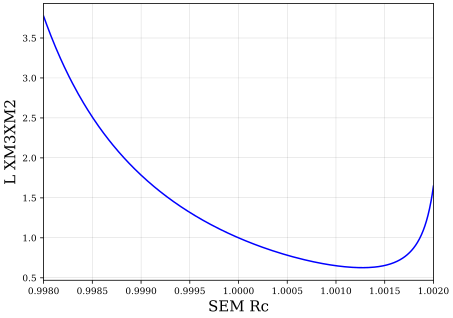

In [41]:
L2_arr = np.linspace(0.998, 1.002, 1000)
# L2_arr = np.linspace(0.99, 1.01, 100000)

fig, ax = plt.subplots(figsize=(7, 5))
for R3_val in [1]:
    Rc_sym_3 = simplify(Rc_sym_2.subs({R3:R3_val}).evalf())
    SEMRc_arr = lambdify(L2, Rc_sym_3)(L2_arr)/SEMRc

    ax.plot(L2_arr, SEMRc_arr)
ax.set_ylabel("L XM3XM2", fontsize=15) 
ax.set_xlabel("SEM Rc", fontsize=15);

In [42]:
SEMRc = -79.59188167302904
solve(Rc_sym_3-SEMRc, L2, dict=True)

[{L2: 0.999999927834891}, {L2: 1.00186190031172}]

In [43]:
LXM3XM2s = []
RcXM3_vals = np.linspace(95, 105,50)
RcXM3_vals = RcXM3_vals/R3_num
for RcXM3_val in RcXM3_vals:
    Rc_sym_3 = simplify(Rc_sym_2.subs({R3:RcXM3_val}).evalf())
    sol = solve(Rc_sym_3-SEMRc, L2, dict=True)
    LXM3XM2s.append((sol[0][L2], sol[1][L2]))
LXM3XM2s = np.array(LXM3XM2s)

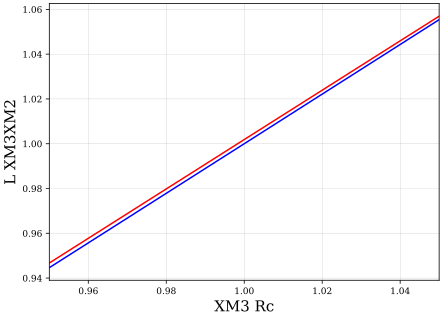

In [44]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(RcXM3_vals, LXM3XM2s[:,0])
ax.plot(RcXM3_vals, LXM3XM2s[:,1])
ax.set_ylabel("L XM3XM2", fontsize=15) 
ax.set_xlabel("XM3 Rc", fontsize=15);

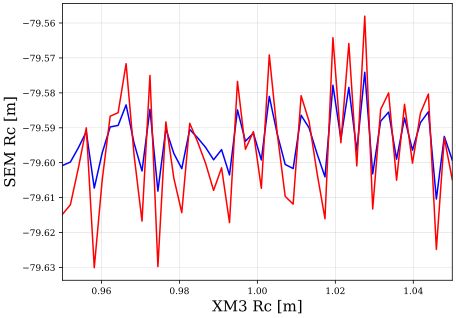

In [46]:
kat1 = kat.deepcopy()
ITMX_TO_SEM1 = kat1.path(kat1.ITMX.p1, kat1.SEM.p1)
pb_SEC1 = kat1.propagate_beam(path=ITMX_TO_SEM1, symbolic=True)
Rc = pb_SEC1.q(kat1.SEM.p1.i).Rc

Rc_evals1 = Rc.eval(subs={'lXM2_XM3.L': LXM3XM2s[:,0].astype(np.float64)*L2_num, 'XM3.Rcx': np.array(RcXM3_vals)*R3_num})
Rc_evals2 = Rc.eval(subs={'lXM2_XM3.L': LXM3XM2s[:,1].astype(np.float64)*L2_num, 'XM3.Rcx': np.array(RcXM3_vals)*R3_num})

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(RcXM3_vals, Rc_evals1)
ax.plot(RcXM3_vals, Rc_evals2)
ax.set_ylabel("SEM Rc [m]", fontsize=15) 
ax.set_xlabel("XM3 Rc [m]", fontsize=15);

In [45]:
variables = """
# ------------------------------------------------------------------------------
# variables
# ------------------------------------------------------------------------------
variable nsilica 1.44963098985906
variable Mloss 30u

variable L_ARM 40k
variable TM_Rc 25.2049k

variable PRMRc 50
variable SEMRc -50
variable l_PRM_BS 50
variable l_BS_SEM 50

variable l_BS_XM2 50
variable XM2Rc -50
variable l_XM2_XM3 50
variable XM3Rc 50

variable l_XM3_ITMXlens 50

variable ITMX_lensf 10k
"""

base = finesse.Model()
base.parse(variables)
base.parse("""
l l1 P=165
s ll1_PRM l1.p1 PRMAR.p1

# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRMAR R=0 T=0.99996 # compound mirrors PRM, ITMX, and SEM
s sPRMsub PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM R=0.9699915 T=0.03 Rc=PRMRc
s lPRM_BS PRM.p2 BS.p1 L=l_PRM_BS

bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lBS_XM2 BS.p3 XM2.p1 L=l_BS_XM2
bs XM2 T=250u L=37.5u alpha=-1 Rc=XM2Rc
s lXM2_XM3 XM2.p2 XM3.p1 L=l_XM2_XM3
bs XM3 T=0 L=37.5u alpha=1 Rc=XM3Rc
s lXM3_ITMXlens XM3.p2 ITMX_lens.p1 L=l_XM3_ITMXlens

lens ITMX_lens ITMX_lensf

s lITMX ITMX_lens.p2 ITMXAR.p1

m ITMXAR T=0.99998 L=20u
s sITMXsub1 ITMXAR.p2 ITMX.p1 L=0.4 nr=nsilica
m ITMX T=0.014 L=Mloss phi=0 Rc=-TM_Rc

s LY ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=Mloss phi=0 Rc=TM_Rc

cav cavXARM source=ITMX.p2.o via=ETMX.p1.i priority=2
#cav cavPRX PRM.p2.o via=ITMX.p1.i priority=1
# ------------------------------------------------------------------------------
# Sginal recycling cavity
# ------------------------------------------------------------------------------
s lBS_SEM BS.p4 SEM.p1 L=l_BS_SEM
m SEM R=0.7999913 T=0.2 L=8.7u Rc=SEMRc
s SEMsub SEM.p2 SEMAR.p1 L=0.0749 nr=nsilica
m SEMAR R=0 T=0.99999995 L=50n
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Power detectors
# ------------------------------------------------------------------------------
"""
)

kat = base.deepcopy()

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30

XM2Rc = -9.6
XM3Rc = 100
ITMX_lensf = np.inf

# SEMRc = -79.59188
PRMRc = 50
l_PRM_BS = 50

kat.PRMRc.value = PRMRc
# kat.SEMRc.value = SEMRc
kat.l_PRM_BS.value = l_PRM_BS
kat.l_BS_SEM.value = l_BS_SEM
kat.l_BS_XM2.value = l_BS_XM2
kat.XM2Rc.value = XM2Rc
kat.l_XM2_XM3.value = l_XM2_XM3
kat.XM3Rc.value = XM3Rc
kat.l_XM3_ITMXlens.value = l_XM3_ITMXlens
kat.ITMX_lensf.value = ITMX_lensf